# Elastic workflow

This is a elastic workflow that is based on a stress-strain approach.

If you want to read more about this approach, please check out [https://docs.materialsproject.org/methodology/materials-methodology/elasticity](https://docs.materialsproject.org/methodology/materials-methodology/elasticity) and the following publication [https://www.nature.com/articles/sdata20159](https://www.nature.com/articles/sdata20159).


## Let's start with the workflow

We now simply load the force field elastic workflow. We change from the default universal ML potential to M3GNet. For CHGNet, an updated version of the ML potential needs to be used: [https://github.com/CederGroupHub/chgnet/issues/79](https://github.com/CederGroupHub/chgnet/issues/79)



In [1]:
from jobflow import run_locally
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from atomate2.forcefields.flows.elastic import ElasticMaker
from atomate2.forcefields.jobs import M3GNetRelaxMaker

structure = Structure(
    lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
    species=["Si", "Si"],
    coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
)

structure= SpacegroupAnalyzer(structure).get_primitive_standard_structure()

elastic_flow = ElasticMaker(
    bulk_relax_maker=M3GNetRelaxMaker(
        relax_cell=True, relax_kwargs={"fmax": 0.00001}
    ),
    elastic_relax_maker=M3GNetRelaxMaker(
        relax_cell=False, relax_kwargs={"fmax": 0.00001}
    ),
).make(structure)


## Let's have a look at the computing jobs
The phonon run will first perform a bulk relaxation, then the displacements are generated and run.
As we currently don't have a way to compute BORN charges with such potentials, a non-analytical term correction is not performed here.


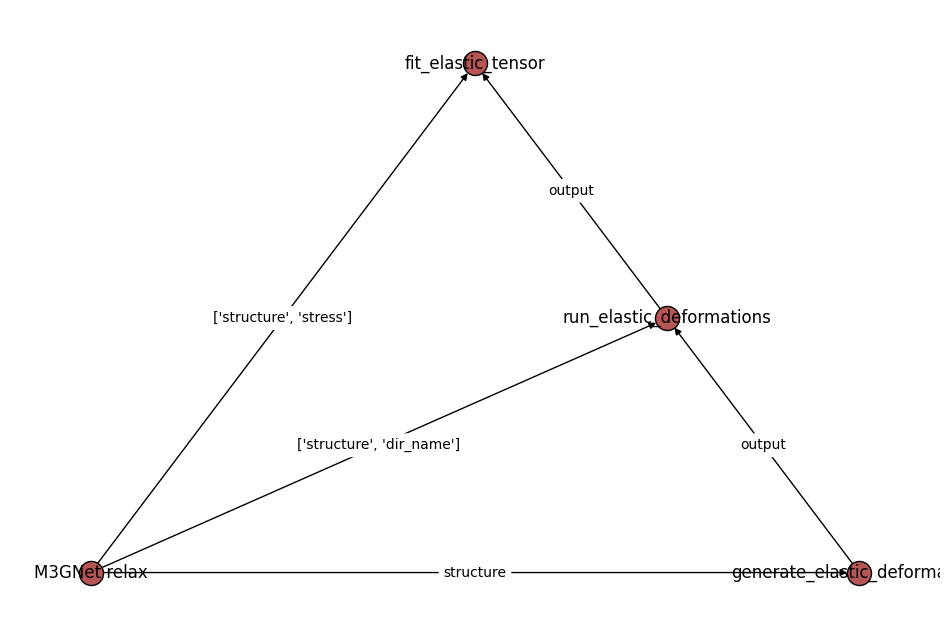

In [2]:
elastic_flow.draw_graph().show()

## Let's execute the workflow

In [3]:

from jobflow import run_locally

responses = run_locally(elastic_flow,  create_folders=True)

2023-10-23 19:04:52,783 INFO Started executing jobs locally


2023-10-23 19:04:52,807 INFO Starting job - M3GNet relax (253a354a-e978-43c0-923b-1246f92948e0)


2023-10-23 19:05:03,717 INFO Finished job - M3GNet relax (253a354a-e978-43c0-923b-1246f92948e0)


2023-10-23 19:05:03,734 INFO Starting job - generate_elastic_deformations (c876529d-9fc6-408e-bfb7-a88d7d200fb6)


2023-10-23 19:05:04,424 INFO Finished job - generate_elastic_deformations (c876529d-9fc6-408e-bfb7-a88d7d200fb6)


2023-10-23 19:05:04,428 INFO Starting job - run_elastic_deformations (3cf2634b-0ab8-47bd-bd7f-c085a6d6d48f)


{}
{}
2023-10-23 19:05:04,601 INFO Finished job - run_elastic_deformations (3cf2634b-0ab8-47bd-bd7f-c085a6d6d48f)


2023-10-23 19:05:04,612 INFO Starting job - M3GNet relax 1/6 (623198c3-61be-417b-9b13-7649dd63d43a)


2023-10-23 19:05:04,975 INFO Finished job - M3GNet relax 1/6 (623198c3-61be-417b-9b13-7649dd63d43a)


2023-10-23 19:05:04,982 INFO Starting job - M3GNet relax 2/6 (d58ed00e-dee2-4aa0-aa69-92806f98b4cd)


2023-10-23 19:05:05,324 INFO Finished job - M3GNet relax 2/6 (d58ed00e-dee2-4aa0-aa69-92806f98b4cd)


2023-10-23 19:05:05,329 INFO Starting job - M3GNet relax 3/6 (ec94ace0-cd4d-44b6-908d-4f8b4f99735e)


2023-10-23 19:05:05,665 INFO Finished job - M3GNet relax 3/6 (ec94ace0-cd4d-44b6-908d-4f8b4f99735e)


2023-10-23 19:05:05,670 INFO Starting job - M3GNet relax 4/6 (50d59b55-b916-4905-b691-cbfd2cd601a8)


2023-10-23 19:05:06,005 INFO Finished job - M3GNet relax 4/6 (50d59b55-b916-4905-b691-cbfd2cd601a8)


2023-10-23 19:05:06,011 INFO Starting job - M3GNet relax 5/6 (26357858-30fe-4c68-84a5-a87c94d724db)


2023-10-23 19:05:13,426 INFO Finished job - M3GNet relax 5/6 (26357858-30fe-4c68-84a5-a87c94d724db)


2023-10-23 19:05:13,444 INFO Starting job - M3GNet relax 6/6 (80d78f7a-ad55-49cc-b670-ad817e1e881f)


2023-10-23 19:05:21,358 INFO Finished job - M3GNet relax 6/6 (80d78f7a-ad55-49cc-b670-ad817e1e881f)


2023-10-23 19:05:21,369 INFO Starting job - store_inputs (3cf2634b-0ab8-47bd-bd7f-c085a6d6d48f, 2)


2023-10-23 19:05:21,373 INFO Finished job - store_inputs (3cf2634b-0ab8-47bd-bd7f-c085a6d6d48f, 2)


2023-10-23 19:05:21,377 INFO Starting job - fit_elastic_tensor (4571316c-75eb-40ed-87af-aad376b1b660)


2023-10-23 19:05:21,934 INFO fit_elastic_tensor failed with exception:
Traceback (most recent call last):
  File "/home/jgeorge/miniconda3/envs/PrepareADISWorkshop/lib/python3.10/site-packages/jobflow/managers/local.py", line 102, in _run_job
    response = job.run(store=store)
  File "/home/jgeorge/miniconda3/envs/PrepareADISWorkshop/lib/python3.10/site-packages/jobflow/core/job.py", line 583, in run
    response = function(*self.function_args, **self.function_kwargs)
  File "/hpc-user/jgeorge/PycharmProjects/PrepareADISWorkshop/atomate2/src/atomate2/common/jobs/elastic.py", line 220, in fit_elastic_tensor
    return ElasticDocument.from_stresses(
  File "/hpc-user/jgeorge/PycharmProjects/PrepareADISWorkshop/atomate2/src/atomate2/common/schemas/elastic.py", line 220, in from_stresses
    derived_properties = DerivedProperties(**property_dict)
  File "/home/jgeorge/miniconda3/envs/PrepareADISWorkshop/lib/python3.10/site-packages/pydantic/main.py", line 164, in __init__
    __pydantic_s

2023-10-23 19:05:21,935 INFO Finished executing jobs locally


## Let's have a look at the outputs

We query our database for the relevant outputs (here results from the elastic document)


In [4]:
from jobflow import SETTINGS

store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    {"name": "fit_elastic_tensor"},
    properties=[
        "output.elastic_tensor",
        "output.derived_properties",
    ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
)

You can then access the elastic tensor in different output formats:

In [5]:
print(result["output"]["elastic_tensor"]["ieee_format"])


[[137.9323798710416, 108.55391971796415, 108.55392012177208, -4.5695166456233035e-08, -5.523558794033493e-07, 1.7030289102383204e-06], [108.55391971796415, 137.93239980948493, 108.55392796763137, -6.195183471739316e-08, -4.074132233397198e-07, 1.596095639781458e-06], [108.55392012177208, 108.5539279676314, 137.9324008356699, -5.8061871494217866e-08, -5.176734278261386e-07, 1.256140336409571e-06], [-4.569516645391779e-08, -6.195183471710404e-08, -5.8061871494489486e-08, 19.309754937637194, 2.2344435192030606e-07, -7.247134868582387e-08], [-5.523558794044879e-07, -4.074132233394308e-07, -5.176734278267169e-07, 2.234443519203083e-07, 19.30975354200256, -8.128338175589485e-09], [1.7030289102380303e-06, 1.5960956397823258e-06, 1.2561403364084115e-06, -7.247134868582273e-08, -8.128338175588074e-09, 19.309753470172556]]


And, derived properties such as bulk moduli can be accessed:

In [6]:
print(result["output"]["derived_properties"])

{'k_voigt': 118.34674623677019, 'k_reuss': 118.34674623676803, 'k_vrh': 118.3467462367691, 'g_voigt': 17.46154657055106, 'g_reuss': 17.151715963562555, 'g_vrh': 17.306631267056808, 'universal_anisotropy': 0.09032058589553849, 'homogeneous_poisson': 0.4302802064586621, 'y_mod': 49506664283.49989, 'trans_v': 2746.5430872791108, 'long_v': 7851.253942135118, 'snyder_ac': 56.10462917254751, 'snyder_opt': 0.20564232813609762, 'snyder_total': 56.31027150068361, 'clark_thermalcond': None, 'cahill_thermalcond': 0.9973763579066814, 'debye_temperature': 340.5643890428059}
